In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata
import time
from datetime import date

sys.path.append('/home/ollie/loziel/pyfesom2/SkillMetrics')
import skill_metrics as sm
import cartopy.crs as ccrs
import pickle

sys.path.append('/home/ollie/loziel/pyfesom2/')
import pyfesom2 as pf
import matplotlib.cm as cm
import cmocean.cm as cmo

In [2]:
var = 'DIN'

In [3]:
# run paths -------------------------------------------------------------------------------------
## you can use an automatic incrementation of result paths below

base_resultpath = '/work/ollie/loziel/model_output/fesom2.1_recom/B'
run_names=['03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']
#run_names=['02','03','04','05','06','07','08','11','14','15']
number_of_runs = np.size(run_names)

resultpath = [None] * number_of_runs
for i in range(0,number_of_runs):
    resultpath[i] = base_resultpath+run_names[i]

## Or you can enter the result paths mannually here

# resultpath1 = ['/work/ollie/loziel/model_output/fesom2.0_recom/B01',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B02',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B03',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B04',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B05',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B06',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B07',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B08',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B09',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B10',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B11',
# '/work/ollie/loziel/model_output/fesom2.0_recom/B12']

# Choose number of columns you want in the plot
number_of_columns = 4
number_of_lines = int(number_of_runs / number_of_columns)

# Choose figure size
figure_size = (15,15)

In [4]:
# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/loziel/pyfesom2/outputs/B0112/'
htmlname     =  'comparison_DIN_' + today +'.html'
htmlpath = '/home/ollie/loziel/pyfesom2/outputs/B0112/'
export_html = False

meshpath = '/work/ollie/loziel/mesh/core2_meanz'

# period of analysis ------------------------------------------------------------------------------------

first_year = 1958
last_year  = 1968

years = np.arange(first_year,last_year+1,1)

# just to check
print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
    resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))

Processing years 1958 to 1968

Reading out of ['/work/ollie/loziel/model_output/fesom2.1_recom/B03', '/work/ollie/loziel/model_output/fesom2.1_recom/B04', '/work/ollie/loziel/model_output/fesom2.1_recom/B05', '/work/ollie/loziel/model_output/fesom2.1_recom/B06', '/work/ollie/loziel/model_output/fesom2.1_recom/B07', '/work/ollie/loziel/model_output/fesom2.1_recom/B08', '/work/ollie/loziel/model_output/fesom2.1_recom/B09', '/work/ollie/loziel/model_output/fesom2.1_recom/B10', '/work/ollie/loziel/model_output/fesom2.1_recom/B11', '/work/ollie/loziel/model_output/fesom2.1_recom/B12', '/work/ollie/loziel/model_output/fesom2.1_recom/B13', '/work/ollie/loziel/model_output/fesom2.1_recom/B14', '/work/ollie/loziel/model_output/fesom2.1_recom/B15', '/work/ollie/loziel/model_output/fesom2.1_recom/B16', '/work/ollie/loziel/model_output/fesom2.1_recom/B17', '/work/ollie/loziel/model_output/fesom2.1_recom/B18']
Storing graphs to /home/ollie/loziel/pyfesom2/outputs/B0112/
Storing html to /home/ollie/

In [5]:
# years as array for x axis
xyears = range(first_year, last_year+1)

# mesh initialization 
mesh = pf.load_mesh(meshpath)

/work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2


# Load World Ocean Atlas 2018

In [6]:
# load WOA DIN -------------------------------------------------------------------------------------
ncfileDSi                = '/work/ollie/projects/MarESys/evaluation/woa18_all_n00_01.nc'
#!ncdump -h $ncfileDIN

labelwoa = 'World Ocean Atlas DIN'
unitwoa = 'DIN [$\mu$mol L$^{-1}$]'

f          = Dataset(ncfileDSi, 'r')
DepthRaw   = -f.variables['depth'][:]                                
lonwoa     =  f.variables['lon'][:]
latwoa     =  f.variables['lat'][:]
Timewoa     =  f.variables['time'][:]
DINwoa     =  f.variables['n_an'][:]
DINwoa     = np.squeeze(DINwoa)
DINwoa     = np.ma.filled(DINwoa, np.nan)                            # From masked array to numpy array

X360, Y180 = np.meshgrid(lonwoa, latwoa)

print('WOA Shape DINwoa: {0} \nDepths n = {1} \nValues: {2}'.format(np.shape(DINwoa),len(DepthRaw),DepthRaw.view())) # depth, lat, lon

# compare to FESOM mesh
print('\nFESOM: \nDepths n = {0} \nValues: {1}'.format(len(mesh.zlev), mesh.zlev))

WOA Shape DINwoa: (102, 180, 360) 
Depths n = 102 
Values: [-0.0 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 -45.0 -50.0 -55.0
 -60.0 -65.0 -70.0 -75.0 -80.0 -85.0 -90.0 -95.0 -100.0 -125.0 -150.0
 -175.0 -200.0 -225.0 -250.0 -275.0 -300.0 -325.0 -350.0 -375.0 -400.0
 -425.0 -450.0 -475.0 -500.0 -550.0 -600.0 -650.0 -700.0 -750.0 -800.0
 -850.0 -900.0 -950.0 -1000.0 -1050.0 -1100.0 -1150.0 -1200.0 -1250.0
 -1300.0 -1350.0 -1400.0 -1450.0 -1500.0 -1550.0 -1600.0 -1650.0 -1700.0
 -1750.0 -1800.0 -1850.0 -1900.0 -1950.0 -2000.0 -2100.0 -2200.0 -2300.0
 -2400.0 -2500.0 -2600.0 -2700.0 -2800.0 -2900.0 -3000.0 -3100.0 -3200.0
 -3300.0 -3400.0 -3500.0 -3600.0 -3700.0 -3800.0 -3900.0 -4000.0 -4100.0
 -4200.0 -4300.0 -4400.0 -4500.0 -4600.0 -4700.0 -4800.0 -4900.0 -5000.0
 -5100.0 -5200.0 -5300.0 -5400.0 -5500.0]

FESOM: 
Depths n = 48 
Values: [ 0.00e+00 -5.00e+00 -1.00e+01 -2.00e+01 -3.00e+01 -4.00e+01 -5.00e+01
 -6.00e+01 -7.00e+01 -8.00e+01 -9.00e+01 -1.00e+02 -1.15e+02 -1.35e+02
 -1.60e

In [7]:
# interpolation specification ------------------------------------------------------------------------------------
use_pickle = False
pickle_file = 'TEMP_woa_din_interpolated'

if(use_pickle == False):
    # original py_recom code:
    #do2_int = np.zeros(len(mesh.z3))                                  # initializing target field for interpolation 
    #for k in range(0,len(mesh.zlevs)):

    # check maximum depth in WOA compared to FESOM
    dmin_woa = np.min(DepthRaw)
    dmin_fesom = np.min(mesh.zlev)

    if(dmin_woa <= dmin_fesom):
        print('***\nDepth greater in WOA ({0}) than in FESOM ({1})'.format(dmin_woa, dmin_fesom))
        ilev = len(mesh.zlev)
        max_zlev = mesh.zlev[ilev-1]
    else:
        print('***\nDepth greater in FESOM ({1}) than in WOA ({0})'.format(dmin_woa, dmin_fesom))
        ilev = np.where(mesh.zlev >= dmin_woa)
        ilev = ilev[0][-1]
        max_zlev = mesh.zlev[ilev]

    print('Please consider choosing max depth level {0} with max depth at {1}!\n***'.format(ilev,max_zlev))
    
    # storage container
    din_int = np.zeros((len(mesh.zlev)-1,len(mesh.x2)))
    #print(np.shape(din_int))
    
    for k in range(0,len(mesh.zlev)-1): # -1 because midlevel is used...
        lev = mesh.zlev[k] # current FESOM depth
        try:
            nextlev = mesh.zlev[k+1] # next level needed because FESOM data is defined for midlevel??
        except:
            print('reached bottom... no midlevel could be calculated')
        finally:
            midlev = (lev + nextlev )/2 # FESOM data is expected to be at midlevel?!
            #print(lev)
        ind1 = np.where(DepthRaw >= midlev)
        ind1 = ind1[0][-1]
        ind2 = np.where(DepthRaw < midlev)[0]

        if ind2.size > 0:                            # If we have not yet reached the bottom
            ind2 = ind2[0]                           # The index of the depth level below the current fesom level
            c    = DepthRaw[ind1]-DepthRaw[ind2]     # Difference in depth between the data value above and below the fesom depth
            c1   = DepthRaw[ind1]-midlev                # Difference between fesom depth and data depth above
            c2   = -(DepthRaw[ind2]-midlev)             # Difference between fesom depth and data depth below
            c1   = (c-c1)/c                          # Scaling coefficient for the depth above
            c2   = (c-c2)/c                          # Scaling coefficient for the depth below
        else:                                        # We have reached the bottom
            c1   = 1.
            c2   = 0.
            ind2 = ind1

        indZ  = np.where(mesh.zlev == lev)                               
        # original code:
        # indZ  = np.where(-mesh.z3 == lev)          # Find the mesh index of the current fesom depth
        indZ = indZ[0] 
        if(False):
            print('\nFESOM depth = {0} -> midlevel = {8}, WOA depths = {1}, {2} \nDepth indices: {3} {4},  FESOM index: {5} \nScaling c1 = {6}, c2 = {7}'.format(lev,DepthRaw[ind1],DepthRaw[ind2],ind1, ind2,indZ,c1,c2,midlev))


        aux1  = DINwoa[ind1,:,:]                     # Find the data above the current fesom depth
        aux2  = DINwoa[ind2,:,:]                     # Find the data below the current fesom depth
        aux   = np.squeeze(c1*aux1+c2*aux2)          # Scaling the data according to vertical distribution as found above
        ind   = np.squeeze(~np.isnan(aux)) 
        #print(np.shape(aux), np.shape(ind))

        # first interpolation to original grid to close empty parts
        aux = griddata((X360[ind], Y180[ind]), aux[ind], (X360, Y180), method='nearest')                             
        # 2D field without nans                           

        # second interpolation to FESOM grid
        din_int[indZ,:] = griddata((X360.ravel(), Y180.ravel()), aux.ravel(), 
                               (mesh.x2, mesh.y2), method='nearest')  
        # Final interpolated field

        if np.isnan(np.min(din_int)): print('WARNING: The interpolated field contains NaNs at depth',lev)                 # Testing if results contain NaNs. If yes, the routine needs adjustments

        #print('Depth: {0} min = {1} max = {2} mean = {3}'.format(lev,np.min(din_int), np.max(din_int), np.mean(din_int)))

    din_int = np.swapaxes(din_int,0,1) # adjust axes layout to FESOM output
    #print(np.shape(din_int))
    
    outfile = open(pickle_file, "wb")
    pickle.dump(din_int,outfile)    
    outfile.close()
    
else:
    try:
        ifile = open(pickle_file, "rb")
        din_int = pickle.load(ifile)
        ifile.close()
    except:
        print('pickle file does not exist!')

***
Depth greater in FESOM (-6250.0) than in WOA (-5500.0)
Please consider choosing max depth level 44 with max depth at -5400.0!
***


# Load FESOM2 data

In [8]:
# check variables
NCfesom = resultpath[0] + '/DIN.fesom.1850.nc'
!ncdump -h $NCfesom

ncdump: /work/ollie/loziel/model_output/fesom2.1_recom/B03/DIN.fesom.1850.nc: /work/ollie/loziel/model_output/fesom2.1_recom/B03/DIN.fesom.1850.nc: No such file or directory


In [9]:
labelfesom = 'FESOM DIN'
unitfesom = 'DIN [mmol m$^{-3}$]' # equals to mumol/L

In [10]:
# create list of variables
DINfesom_0m_list = [None] * number_of_runs
DINfesom_200m_list = [None] * number_of_runs
DINfesom_2000m_list = [None] * number_of_runs
for i in range(0,number_of_runs):
    DINfesom_0m_list[i] = 'DINfesom_0m_'+run_names[i]
    DINfesom_200m_list[i] = 'DINfesom_200m_'+run_names[i]
    DINfesom_2000m_list[i] = 'DINfesom_2000m_'+run_names[i]
    
print('variables are: ',DINfesom_0m_list, DINfesom_200m_list, DINfesom_2000m_list)

# load data
for i in range(0,number_of_runs):
    DINfesom_0m_list[i] = pf.get_data(resultpath[i], "DIN", years, mesh, how="mean", compute=True, runid='fesom', depth = 0)
    DINfesom_200m_list[i] = pf.get_data(resultpath[i], "DIN", years, mesh, how="mean", compute=True, runid='fesom', depth = 200)
    DINfesom_2000m_list[i] = pf.get_data(resultpath[i], "DIN", years, mesh, how="mean", compute=True, runid='fesom', depth = 2000)

variables are:  ['DINfesom_0m_03', 'DINfesom_0m_04', 'DINfesom_0m_05', 'DINfesom_0m_06', 'DINfesom_0m_07', 'DINfesom_0m_08', 'DINfesom_0m_09', 'DINfesom_0m_10', 'DINfesom_0m_11', 'DINfesom_0m_12', 'DINfesom_0m_13', 'DINfesom_0m_14', 'DINfesom_0m_15', 'DINfesom_0m_16', 'DINfesom_0m_17', 'DINfesom_0m_18'] ['DINfesom_200m_03', 'DINfesom_200m_04', 'DINfesom_200m_05', 'DINfesom_200m_06', 'DINfesom_200m_07', 'DINfesom_200m_08', 'DINfesom_200m_09', 'DINfesom_200m_10', 'DINfesom_200m_11', 'DINfesom_200m_12', 'DINfesom_200m_13', 'DINfesom_200m_14', 'DINfesom_200m_15', 'DINfesom_200m_16', 'DINfesom_200m_17', 'DINfesom_200m_18'] ['DINfesom_2000m_03', 'DINfesom_2000m_04', 'DINfesom_2000m_05', 'DINfesom_2000m_06', 'DINfesom_2000m_07', 'DINfesom_2000m_08', 'DINfesom_2000m_09', 'DINfesom_2000m_10', 'DINfesom_2000m_11', 'DINfesom_2000m_12', 'DINfesom_2000m_13', 'DINfesom_2000m_14', 'DINfesom_2000m_15', 'DINfesom_2000m_16', 'DINfesom_2000m_17', 'DINfesom_2000m_18']
Model depth: 0.0
Model depth: 190.0
M

array([<GeoAxesSubplot:title={'center':'03'}>,
       <GeoAxesSubplot:title={'center':'04'}>,
       <GeoAxesSubplot:title={'center':'05'}>,
       <GeoAxesSubplot:title={'center':'06'}>,
       <GeoAxesSubplot:title={'center':'07'}>,
       <GeoAxesSubplot:title={'center':'08'}>,
       <GeoAxesSubplot:title={'center':'09'}>,
       <GeoAxesSubplot:title={'center':'10'}>,
       <GeoAxesSubplot:title={'center':'11'}>,
       <GeoAxesSubplot:title={'center':'12'}>,
       <GeoAxesSubplot:title={'center':'13'}>,
       <GeoAxesSubplot:title={'center':'14'}>,
       <GeoAxesSubplot:title={'center':'15'}>,
       <GeoAxesSubplot:title={'center':'16'}>,
       <GeoAxesSubplot:title={'center':'17'}>,
       <GeoAxesSubplot:title={'center':'18'}>], dtype=object)

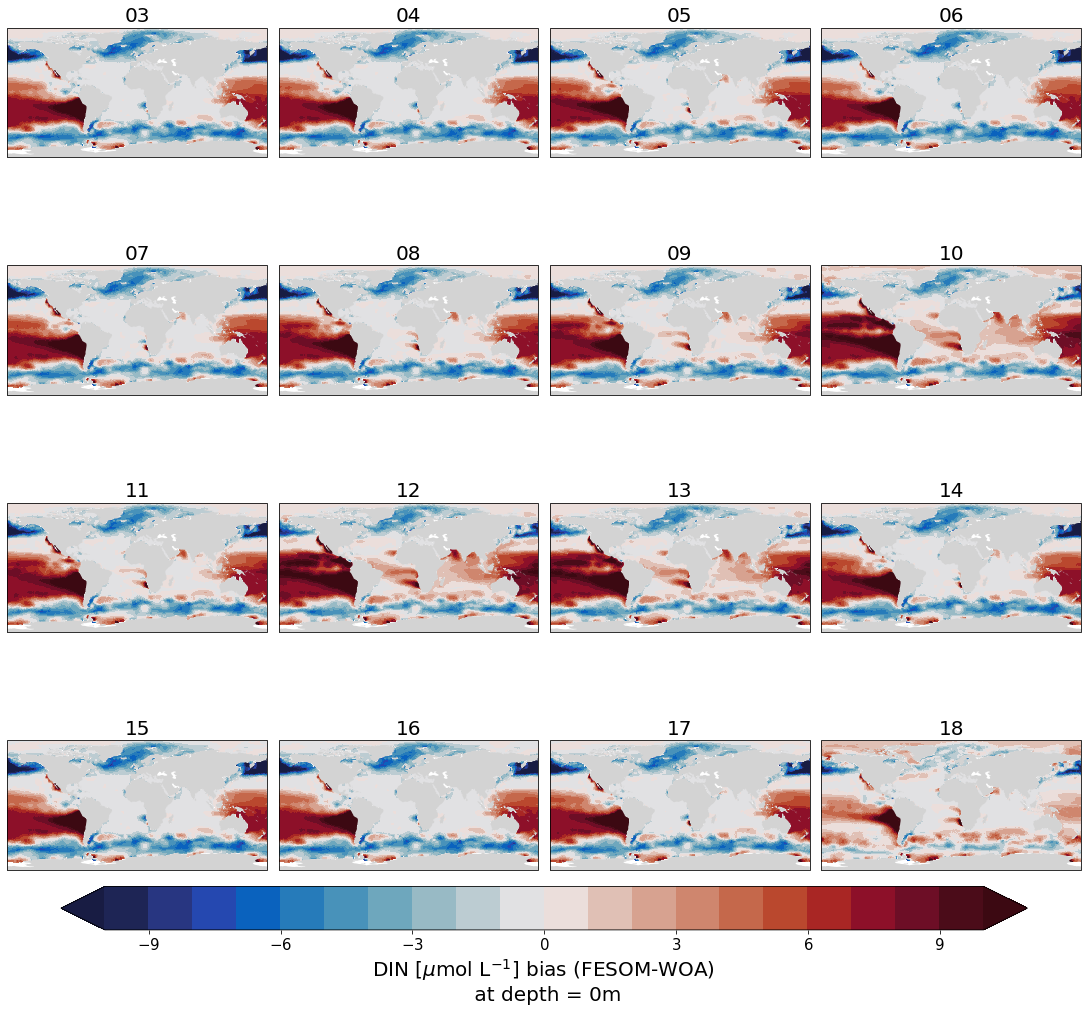

In [11]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_0m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 0)))

data = []
for i in range(0,number_of_runs):
    data.append(DINfesom_0m_list[i]-din_int_ma[:,ind_depth])
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-10,10,21),
        units=unitwoa+ ' bias (FESOM-WOA) \n at depth = 0m',
        titles = run_names,
        rowscol=[number_of_lines,number_of_columns],
        figsize=figure_size,
        cmap=cmo.balance,
       )

array([<GeoAxesSubplot:title={'center':'03'}>,
       <GeoAxesSubplot:title={'center':'04'}>,
       <GeoAxesSubplot:title={'center':'05'}>,
       <GeoAxesSubplot:title={'center':'06'}>,
       <GeoAxesSubplot:title={'center':'07'}>,
       <GeoAxesSubplot:title={'center':'08'}>,
       <GeoAxesSubplot:title={'center':'09'}>,
       <GeoAxesSubplot:title={'center':'10'}>,
       <GeoAxesSubplot:title={'center':'11'}>,
       <GeoAxesSubplot:title={'center':'12'}>,
       <GeoAxesSubplot:title={'center':'13'}>,
       <GeoAxesSubplot:title={'center':'14'}>,
       <GeoAxesSubplot:title={'center':'15'}>,
       <GeoAxesSubplot:title={'center':'16'}>,
       <GeoAxesSubplot:title={'center':'17'}>,
       <GeoAxesSubplot:title={'center':'18'}>], dtype=object)

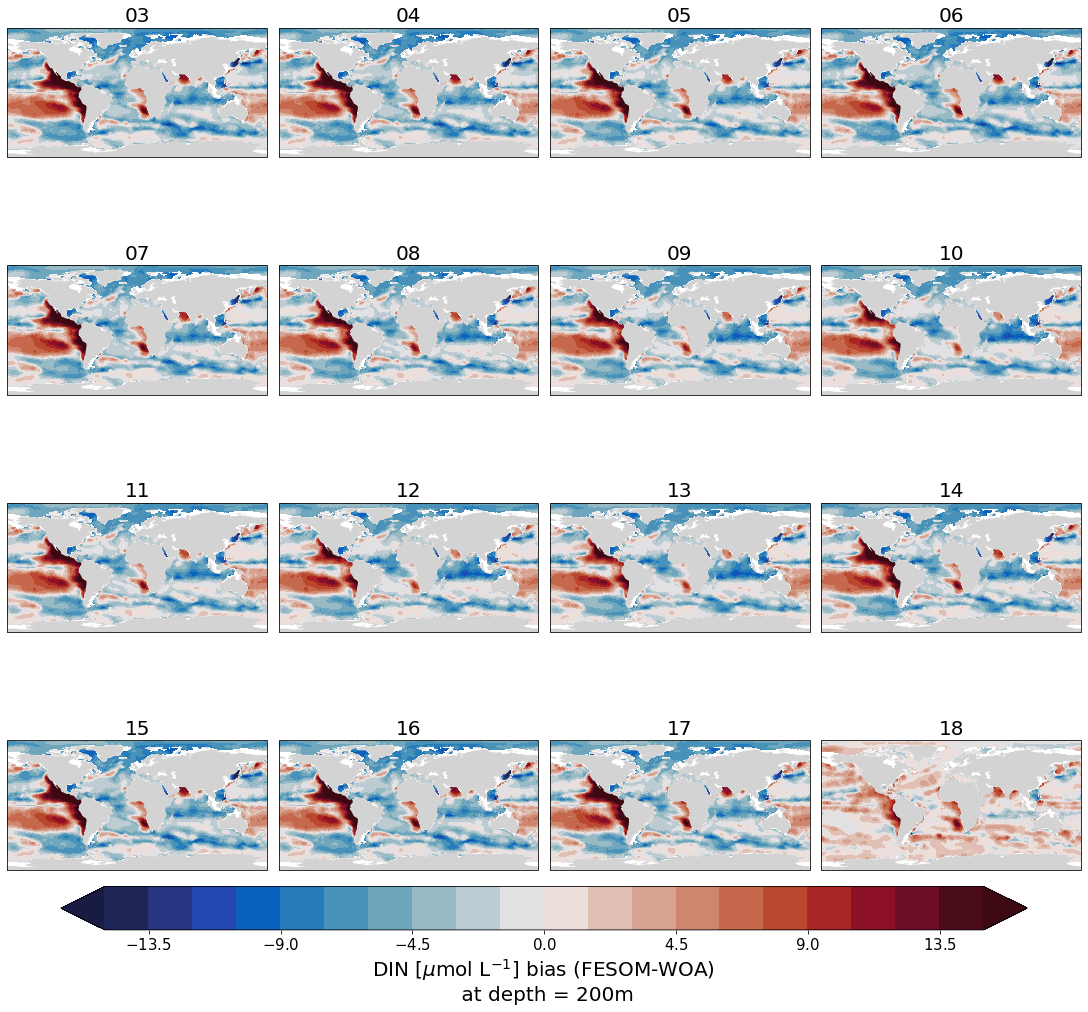

In [12]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_200m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 200)))

data = []
for i in range(0,number_of_runs):
    data.append(DINfesom_200m_list[i]-din_int_ma[:,ind_depth])
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-15,15,21),
        units=unitwoa+ ' bias (FESOM-WOA) \n at depth = 200m',
        titles = run_names,
        rowscol=[number_of_lines,number_of_columns],
        figsize=figure_size,
        cmap=cmo.balance,
       )

array([<GeoAxesSubplot:title={'center':'03'}>,
       <GeoAxesSubplot:title={'center':'04'}>,
       <GeoAxesSubplot:title={'center':'05'}>,
       <GeoAxesSubplot:title={'center':'06'}>,
       <GeoAxesSubplot:title={'center':'07'}>,
       <GeoAxesSubplot:title={'center':'08'}>,
       <GeoAxesSubplot:title={'center':'09'}>,
       <GeoAxesSubplot:title={'center':'10'}>,
       <GeoAxesSubplot:title={'center':'11'}>,
       <GeoAxesSubplot:title={'center':'12'}>,
       <GeoAxesSubplot:title={'center':'13'}>,
       <GeoAxesSubplot:title={'center':'14'}>,
       <GeoAxesSubplot:title={'center':'15'}>,
       <GeoAxesSubplot:title={'center':'16'}>,
       <GeoAxesSubplot:title={'center':'17'}>,
       <GeoAxesSubplot:title={'center':'18'}>], dtype=object)

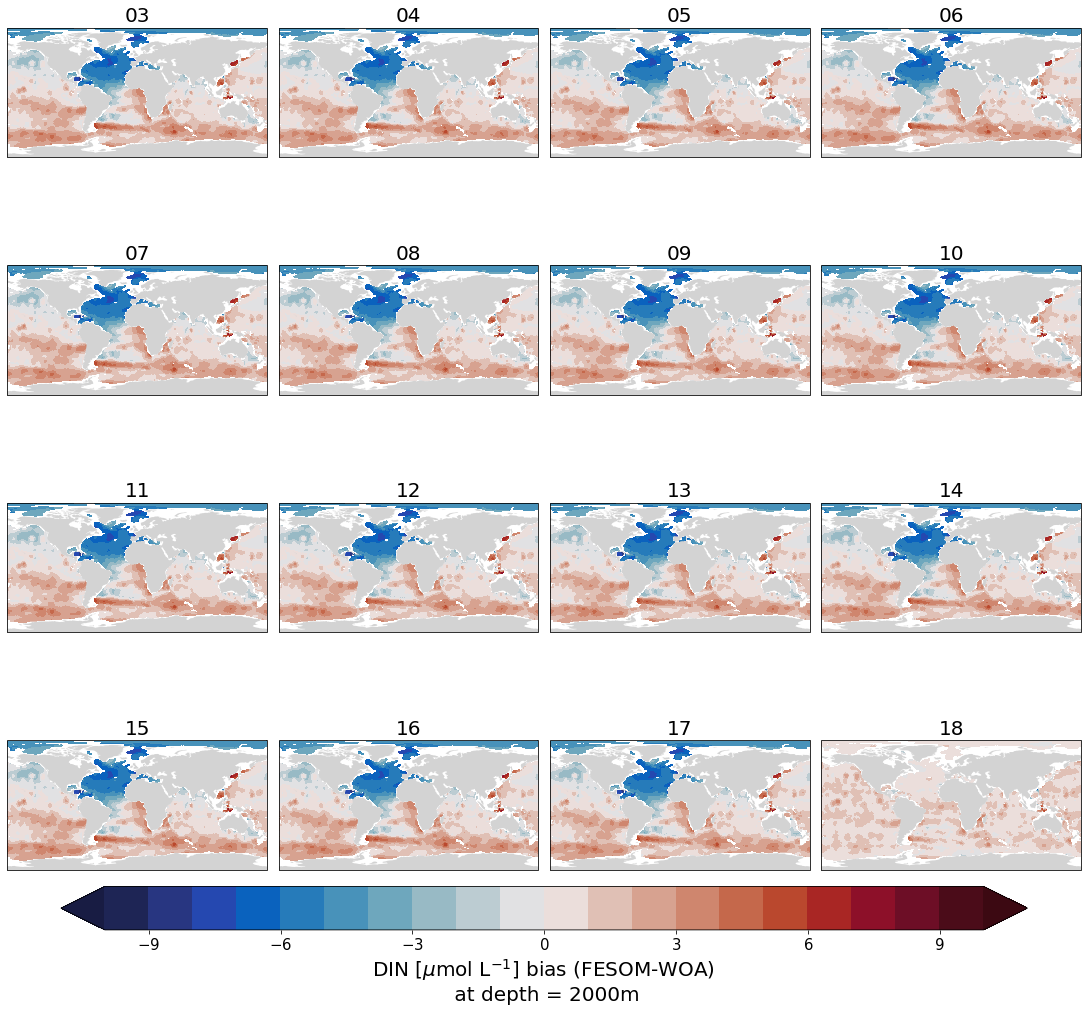

In [13]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_2000m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 2000)))

data = []
for i in range(0,number_of_runs):
    data.append(DINfesom_2000m_list[i]-din_int_ma[:,ind_depth])
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-10,10,21),
        units=unitwoa+ ' bias (FESOM-WOA) \n at depth = 2000m',
        titles = run_names,
        rowscol=[number_of_lines,number_of_columns],
        figsize=figure_size,
        cmap=cmo.balance,
       )

['03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18']

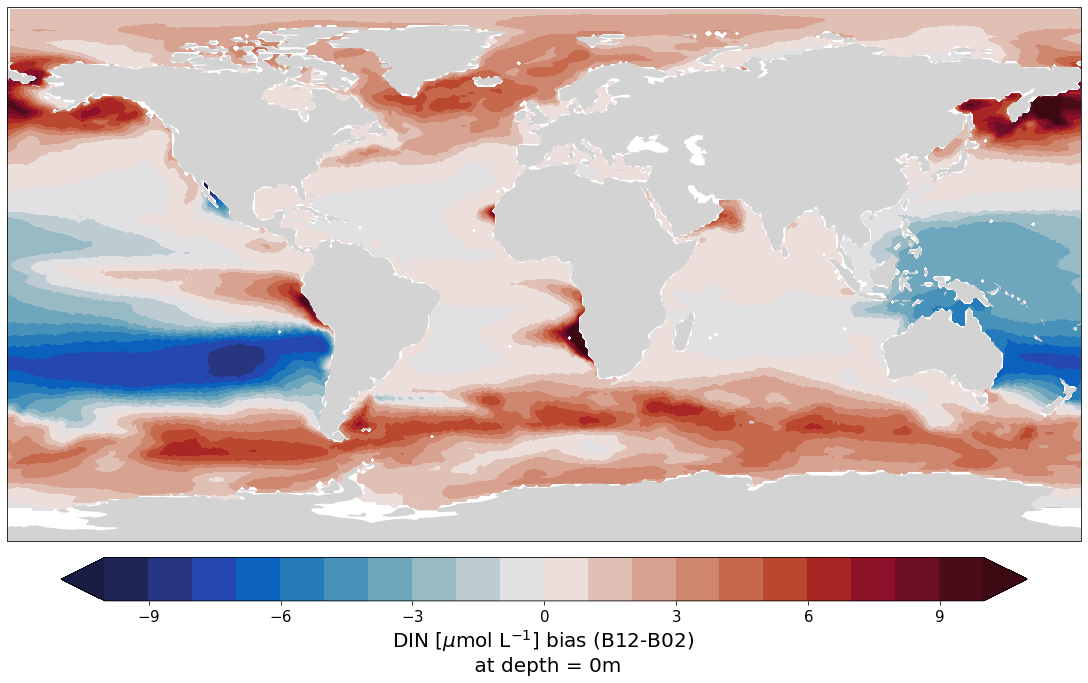

In [14]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_0m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 0)))

data = DINfesom_0m_list[15]-DINfesom_0m_list[12]
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-10,10,21),
        units=unitwoa+ ' bias (B12-B02) \n at depth = 0m',
        rowscol=[1,1],
        figsize=figure_size,
        cmap=cmo.balance,
       )

run_names

In [ ]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_0m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 0)))

data = DINfesom_0m_list[7]-din_int_ma[:,ind_depth]
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-30,30,21),
        units=unitwoa+ ' bias (B01-B03) \n at depth = 0m',
        rowscol=[1,1],
        figsize=figure_size,
        cmap=cmo.balance,
       )

In [ ]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom_0m_list[0] == 0] = 0

ind_depth = int(np.argmin(np.abs(mesh.zlev + 0)))

data = DINfesom_0m_list[1]-din_int_ma[:,ind_depth]
    
# np.shape(data)

pf.plot(mesh, 
        data,
        levels=(-30,30,21),
        units=unitwoa+ ' bias (B01-B03) \n at depth = 0m',
        rowscol=[1,1],
        figsize=figure_size,
        cmap=cmo.balance,
       )